In [40]:
import torch
import torchvision
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

In [41]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import copy

In [42]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [43]:
numb_batch = 64

In [44]:
T = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
train_data = torchvision.datasets.MNIST('mnist_data', train=True, download=True, transform=T)
val_data = torchvision.datasets.MNIST('mnist_data', train=False, download=True, transform=T)

train_dl = torch.utils.data.DataLoader(train_data, batch_size = numb_batch)
val_dl = torch.utils.data.DataLoader(val_data, batch_size = numb_batch)

In [45]:
def create_model():
    model = nn.Sequential(
        nn.Conv2d(1, 6, 5, padding=2),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Conv2d(6, 16, 5, padding=0),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Flatten(),
        nn.Linear(400, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10)
    )
    return model

In [46]:
def validate(model, data, device):
    total = 0
    correct = 0
    for images, labels in data:
        images = images.to(device)
        labels = labels.to(device)

        x = model(images)
        _, pred = torch.max(x, 1)
        pred = pred.cpu()  # Move predictions back to CPU if they were on GPU
        total += labels.size(0)
        correct += torch.sum(pred == labels.cpu())  # Move labels back to CPU for comparison

    return correct * 100. / total


In [47]:
def train(numb_epoch=3, lr=1e-3, device="cpu"):
    accuracies = []
    best_model = cnn = create_model().to(device)
    cec = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr)
    max_accuracy = 0
    max_acc_epoch = 0
    for epoch in range(numb_epoch):
        for images, labels in train_dl:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            pred = cnn(images)
            loss = cec(pred, labels)
            loss.backward()
            optimizer.step()
        accuracy = float(validate(cnn, val_dl, device))
        accuracies.append(accuracy)
        writer.add_scalar("Accuracy/Epoch", accuracy, epoch)
        if accuracy > max_accuracy:
            best_model = copy.deepcopy(cnn)
            max_accuracy = accuracy
            max_acc_epoch = epoch
            print(f"Saving Best Model with Accuracy: {accuracy}%, epoch: {max_acc_epoch}")
        print('Epoch:', epoch+1, "Accuracy :", accuracy, '%')
    plt.plot(accuracies)
    plt.plot(max_acc_epoch, max_accuracy, 'o')
    return best_model, max_accuracy

In [48]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("No Cuda Available")
device

No Cuda Available


device(type='cpu')

Saving Best Model with Accuracy: 95.22000122070312%, epoch: 0
Epoch: 1 Accuracy : 95.22000122070312 %
Saving Best Model with Accuracy: 96.93000030517578%, epoch: 1
Epoch: 2 Accuracy : 96.93000030517578 %
Epoch: 3 Accuracy : 96.76000213623047 %
Saving Best Model with Accuracy: 97.70999908447266%, epoch: 3
Epoch: 4 Accuracy : 97.70999908447266 %
Saving Best Model with Accuracy: 98.29000091552734%, epoch: 4
Epoch: 5 Accuracy : 98.29000091552734 %
Saving Best Model with Accuracy: 98.55000305175781%, epoch: 5
Epoch: 6 Accuracy : 98.55000305175781 %
Saving Best Model with Accuracy: 98.58000183105469%, epoch: 6
Epoch: 7 Accuracy : 98.58000183105469 %
Epoch: 8 Accuracy : 98.5 %
Epoch: 9 Accuracy : 98.54000091552734 %
Epoch: 10 Accuracy : 98.41000366210938 %
Saving Best Model with Accuracy: 98.69999694824219%, epoch: 10
Epoch: 11 Accuracy : 98.69999694824219 %
Saving Best Model with Accuracy: 98.86000061035156%, epoch: 11
Epoch: 12 Accuracy : 98.86000061035156 %


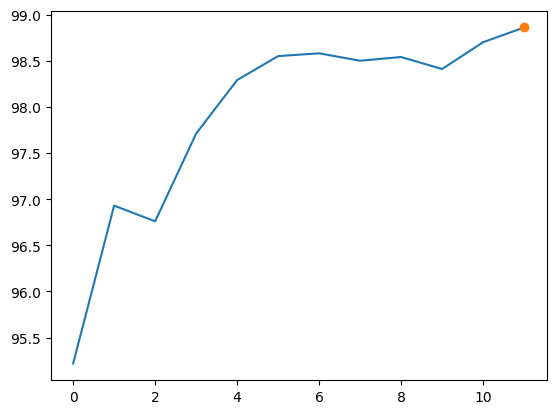

In [49]:
model, max_accuracy = train(12, device=device) # type: ignore

In [50]:
# from datetime import datetime
# ts = datetime.now().strftime('%Y%m%d%H%M%S')

# torch.save(model.state_dict(), f'model_{ts}_{max_accuracy:0.3f}.pth')

In [51]:
# model = create_model().to(device)
# model.load_state_dict(torch.load("model_20240108131819_99.150.pth"))
# model.eval()

In [52]:
def predict_dl(model, data):
    y_pred = []
    y_true = []
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():
        for images, labels in data:
            images = images.to(device)
            labels = labels.to(device)

            x = model(images)
            _, pred = torch.max(x, 1)
            pred = pred.data.cpu()
            
            correct_predictions += torch.sum(pred == labels.data.cpu()).item()
            total_samples += labels.size(0)

            y_pred.extend(list(pred.numpy()))
            y_true.extend(list(labels.numpy()))

    accuracy = (correct_predictions / total_samples) * 100.0

    return np.array(y_pred), np.array(y_true), accuracy


In [53]:
y_pred, y_true, test_accuracy = predict_dl(model, val_dl)
print("Accuracy: ", test_accuracy, "%")
pd.DataFrame(confusion_matrix(y_true, y_pred, labels=np.arange(0,10)))

Accuracy:  98.86 %


,0,1,2,3,4,5,6,7,8,9
0,977,0,0,0,0,0,1,1,1,0
1,2,1132,0,0,0,0,1,0,0,0
2,2,0,1025,2,1,0,0,2,0,0
3,0,0,1,998,0,3,0,4,2,2
4,1,0,2,0,972,0,2,1,0,4
5,1,0,0,5,0,883,1,1,1,0
6,5,4,0,0,2,9,936,0,2,0
7,1,3,4,0,0,0,0,1019,0,1
8,4,0,4,1,2,2,0,2,955,4
9,0,1,1,0,8,4,0,5,1,989
